In [1]:
%%capture
!unzip -o "/content/drive/MyDrive/Thesis/Dataset Backups/FaceForensics Extracted Faces/non_aligned.zip" -d /content/

In [2]:
!cp "/content/drive/MyDrive/Thesis/deepfake-detection-master/ensemble cnn/shape_predictor_68_face_landmarks.dat" .

In [3]:
import os
import tensorflow as tf
import numpy as np
import matplotlib.pyplot as plt
import cv2
import numpy as np
import dlib

In [4]:
print(tf.__version__)
print(tf.keras.__version__)

2.4.1
2.4.0


## Parameters

In [5]:
FACE_SIZE = (128, 128)
EYES_SIZE = (50, 150)
NOSE_SIZE = (100, 50)
LIPS_SIZE = (50, 100)

#Prediction

##Load Model

In [6]:
face_model = tf.keras.models.load_model("/content/drive/MyDrive/Thesis/deepfake-detection-master/ensemble cnn/models/InceptionResNetV2.h5")
eyes_model = tf.keras.models.load_model("/content/drive/MyDrive/Thesis/deepfake-detection-master/ensemble cnn/models/model0.h5")
nose_model = tf.keras.models.load_model("/content/drive/MyDrive/Thesis/deepfake-detection-master/ensemble cnn/models/model1.h5")
lips_model = tf.keras.models.load_model("/content/drive/MyDrive/Thesis/deepfake-detection-master/ensemble cnn/models/model2.h5")

## Store into tf.data.Dataset

In [17]:
face_test = os.path.join('non_aligned', 'testing')

# When shuffle = False, set seed = None (default value)
# When shuffle = false and seed = random int value, 
# then a single image is extracted multiple times

class_names = None
def get_datasets(testing_directory, image_size):
    ds_test = tf.keras.preprocessing.image_dataset_from_directory(
        testing_directory,
        color_mode="rgb",
        batch_size=10000,
        image_size=image_size,
        shuffle=True,
        seed=9,
    )
    global class_names
    class_names = ds_test.class_names
    print(ds_test.class_names)
    
    AUTOTUNE = tf.data.AUTOTUNE
    ds_test = ds_test.prefetch(buffer_size=AUTOTUNE)
    return ds_test

face_ds = get_datasets(face_test, FACE_SIZE)

Found 28000 files belonging to 2 classes.
['fake', 'real']


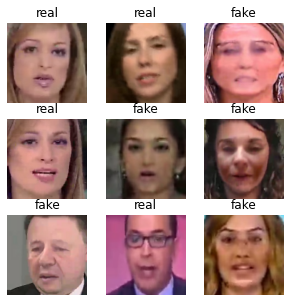

In [18]:
plt.figure(figsize=(5,5))
for images, labels in face_ds.take(1):
    for i in range(9):
        ax = plt.subplot(3, 3, i + 1)
        plt.imshow(images[i].numpy().astype("uint8"))
        plt.title(class_names[labels[i]])
        plt.axis("off")

In [19]:
detector = dlib.get_frontal_face_detector()
predictor = dlib.shape_predictor("shape_predictor_68_face_landmarks.dat")

def extractFacialLandmarks(img, points, scale=5, apply_mask=True):
    if apply_mask:
        mask = np.zeros_like(img)
        mask = cv2.fillPoly(mask, [points], (255,255,255))
        # mask = cv2.GaussianBlur(mask, (9,9), 10)
        img = cv2.bitwise_and(img, mask)
    
    bbox = cv2.boundingRect(points)
    x,y,w,h = bbox
    crop = img[y:y+h, x:x+w]
    crop = cv2.resize(crop, (0,0), None, scale, scale)
    return crop

def getEyePoints(landmarks):
    points = []
    for i in range(17,28):
        x = landmarks.part(i).x
        y = landmarks.part(i).y
        points.append([x,y])
    for i in range(36,42):
        x = landmarks.part(i).x
        y = landmarks.part(i).y
        points.append([x,y])
    for i in range(42,48):
        x = landmarks.part(i).x
        y = landmarks.part(i).y
        points.append([x,y])
    points = np.array(points)
    return points

def getNosePoints(landmarks):
    points = []
    for i in range(27,36):
        x = landmarks.part(i).x
        y = landmarks.part(i).y
        points.append([x,y])
    for i in range(49,54):
        x = landmarks.part(i).x
        y = landmarks.part(i).y
        points.append([x,y])
    points = np.array(points)
    return points

def getLipsPoints(landmarks):
    points = []
    for i in range(48,61):
        x = landmarks.part(i).x
        y = landmarks.part(i).y
        points.append([x,y])
    points = np.array(points)
    return points

def process_batch(batch, label_batch, eye_size=(150,50), lips_size=(100,50), nose_size=(50,100)):
    extracted_eyes = []
    extracted_lips = []
    extracted_nose = []
    original_faces = []
    labels = []

    index = 0
    
    for image in batch:
        frame = image.astype(np.uint8)
        gray = cv2.cvtColor(frame, cv2.COLOR_BGR2GRAY)
        faces = detector(gray)
        
        for face in faces:         
            landmarks = predictor(gray, face)
            
            eyes = extractFacialLandmarks(frame, getEyePoints(landmarks), apply_mask=False)
            lips = extractFacialLandmarks(frame, getLipsPoints(landmarks), apply_mask=False)
            nose = extractFacialLandmarks(frame, getNosePoints(landmarks), apply_mask=False)

            extracted_eyes.append(cv2.resize(eyes, eye_size))
            extracted_lips.append(cv2.resize(lips, lips_size))
            extracted_nose.append(cv2.resize(nose, nose_size))
            original_faces.append(image)
            labels.append(label_batch[index])
        
        index+=1
    
    original_faces = np.array(original_faces)
    extracted_eyes = np.array(extracted_eyes)
    extracted_lips = np.array(extracted_lips)
    extracted_nose = np.array(extracted_nose)
    labels = np.array(labels)
    return original_faces, extracted_eyes, extracted_nose, extracted_lips, labels

##Custom Generators

In [27]:
# Returns a <generator object custom_training_generator>
def test_generator():
    image_batch, label_batch = face_ds.as_numpy_iterator().next()
    face, eyes, nose, lips, labels = process_batch(image_batch, label_batch)

    # images_channel_2 = tf.convert_to_tensor(images_channel_2, dtype=None)
    return [face, eyes, nose, lips, labels], label_batch

images, _ = test_generator()
labels = images[4]

Plotting faces from a single batch from test set...


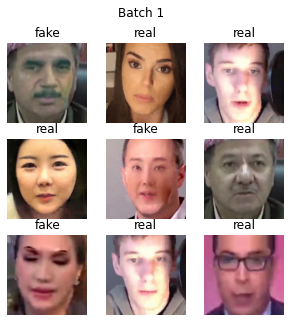

In [28]:
print('Plotting faces from a single batch from test set...')
index = 0
index += 1
fig = plt.figure(figsize=(5, 5))
for i in range(9):
    ax = plt.subplot(3, 3, i + 1)
    plt.imshow(images[0][i].astype('uint8'))
    plt.title(class_names[labels[i]])
    plt.axis("off")
fig.suptitle('Batch ' + str(index))
plt.show()

## Make Predictions

In [29]:
face_predictions = face_model.predict_on_batch(images[0]).flatten()
face_predictions = tf.nn.sigmoid(face_predictions)
face_predictions = tf.where(face_predictions < 0.5, 0, 1)

eyes_predictions = eyes_model.predict_on_batch(images[1]).flatten()
eyes_predictions = tf.where(eyes_predictions < 0.5, 0, 1)

nose_predictions = nose_model.predict_on_batch(images[2]).flatten()
nose_predictions = tf.where(nose_predictions < 0.5, 0, 1)

lips_predictions = lips_model.predict_on_batch(images[3]).flatten()
lips_predictions = tf.where(lips_predictions < 0.5, 0, 1)

print(len(face_predictions))
print(len(eyes_predictions))
print(len(nose_predictions))
print(len(lips_predictions))

9934
9934
9934
9934


In [30]:
predictions = []
for i in range(len(face_predictions)):
    pred = (2*face_predictions[i] + eyes_predictions[i] + nose_predictions[i] + lips_predictions[i])
    if pred > 2:
        predictions.append(1)
    else:
        predictions.append(0)
print(predictions)

[0, 1, 1, 1, 0, 1, 0, 1, 0, 0, 1, 0, 1, 0, 0, 1, 1, 1, 0, 0, 0, 1, 0, 0, 1, 0, 0, 1, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 1, 0, 1, 1, 0, 1, 0, 1, 0, 1, 1, 1, 1, 1, 0, 1, 0, 0, 0, 1, 1, 0, 1, 1, 1, 1, 0, 1, 1, 0, 1, 1, 1, 1, 0, 1, 1, 0, 1, 1, 1, 1, 0, 1, 1, 1, 0, 0, 0, 0, 1, 0, 1, 0, 1, 1, 0, 0, 0, 1, 0, 0, 0, 1, 1, 0, 0, 0, 1, 0, 1, 0, 1, 1, 0, 1, 1, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 1, 0, 0, 1, 0, 0, 0, 0, 0, 0, 1, 0, 0, 1, 0, 0, 0, 0, 0, 1, 0, 0, 1, 1, 0, 0, 0, 1, 1, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 1, 1, 1, 0, 1, 1, 0, 1, 1, 1, 1, 0, 1, 1, 0, 1, 1, 1, 0, 0, 1, 0, 1, 1, 0, 0, 0, 0, 1, 0, 1, 1, 0, 0, 1, 1, 0, 1, 0, 0, 0, 1, 1, 0, 1, 0, 0, 0, 1, 0, 0, 0, 1, 0, 0, 1, 0, 1, 1, 0, 1, 0, 0, 0, 0, 0, 0, 1, 1, 0, 1, 0, 0, 1, 0, 1, 0, 0, 0, 0, 1, 0, 0, 0, 0, 1, 0, 1, 0, 0, 1, 0, 1, 1, 1, 1, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 1, 1, 1, 1, 0, 1, 1, 0, 1, 1, 1, 0, 1, 0, 0, 0, 0, 0, 0, 1, 1, 1, 1, 0, 1, 1, 1, 1, 0, 1, 0, 1, 0, 0, 1, 1, 1, 1, 1, 0, 1, 0, 0, 0, 0, 

In [31]:
from sklearn.metrics import classification_report
classificationReport = classification_report(labels, predictions, target_names=class_names, digits=5)
print(classificationReport)

              precision    recall  f1-score   support

        fake    0.93880   0.95663   0.94763      5003
        real    0.95513   0.93673   0.94584      4931

    accuracy                        0.94675      9934
   macro avg    0.94696   0.94668   0.94673      9934
weighted avg    0.94690   0.94675   0.94674      9934



## Confusion Matrix

In [32]:
#Output confusion matrix
from sklearn.metrics import confusion_matrix

def print_confusion_matrix(y_true, y_pred):
    cm = confusion_matrix(y_true, y_pred)
    print('True positive = ', cm[0][0])
    print('False positive = ', cm[0][1])
    print('False negative = ', cm[1][0])
    print('True negative = ', cm[1][1])
    return cm
    
confusionMatrix = print_confusion_matrix(labels, predictions)

True positive =  4786
False positive =  217
False negative =  312
True negative =  4619


# Write to File

In [33]:
tp = str('True positive = '+ str(confusionMatrix[0][0]) + '\n')
fp = str('False positive = '+ str(confusionMatrix[0][1]) + '\n')
fn = str('False negative = '+ str(confusionMatrix[1][0]) + '\n')
tn = str('True negative = '+ str(confusionMatrix[1][1]) + '\n')

data = (
    'Model Name: ' + 'Ensemble Model' + '\n' +
    'All data below are results of majority voting with ensemble of 4 CNNs' + '\n' +
    '===================================================== \n\n' +
    str(classificationReport) + '\n' + str(tp + fp + fn + tn)
)

from datetime import datetime 
import pytz 
  
# get the standard UTC time  
UTC = pytz.utc 
  
# it will get the time zone  
# of the specified location 
IST = pytz.timezone('Asia/Kolkata') 
  
datetime_ist = datetime.now(IST) 
filename = ('Report ' + datetime_ist.strftime('%Y-%m-%d %H%M') + ' Ensemble' + '.txt')

myFile = open('/content/drive/MyDrive/Thesis/deepfake-detection-master/ensemble cnn/' + filename, 'w')
myFile.write(data)
myFile.close()
